# 空间金字塔池化(Spatial Pyramid Pooling, SPP)

Paper: https://arxiv.org/pdf/1406.4729.pdf

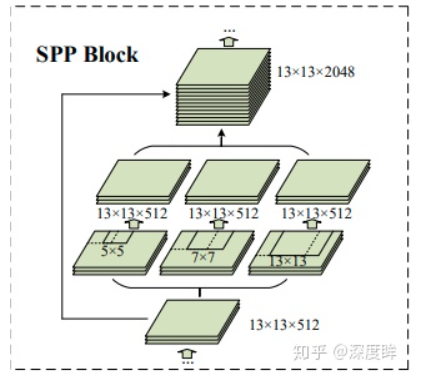

$H_{out}=floor(\frac{H_{in}+2padding[0]-kernerl\_size[0]}{stride[0]}+1)$

$W_{out}=floor(\frac{W_{in}+2padding[1]-kernerl\_size[1]}{stride[1]}+1)$

In [9]:
# Method 1
import torch
from torch import nn

class SPP(nn.Module):
    def __init__(self):
        super(SPP,self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=5,stride=1,padding=5//2)
        self.pool2 = nn.MaxPool2d(kernel_size=7,stride=1,padding=7//2)
        self.pool3 = nn.MaxPool2d(kernel_size=13,stride=1,padding=13//2)
        
    def forward(self,x):    
        x1 = self.pool1(x)
        x2 = self.pool2(x)
        x3 = self.pool3(x)
        return torch.cat([x,x1,x2,x3],dim=1)
    
# 输入的一批数据的数目2
# 输入的通道数512
# 高度和宽度都是13
x = torch.rand((2,512,13,13))    
f = SPP()
#print(f(x))
print('SPP out shape =',f(x).shape)

SPP out shape = torch.Size([2, 2048, 13, 13])


SPP能在输入尺寸任意的情况下产生固定大小的输出，而以前的深度网络中的滑窗池化(sliding window pooling)则不能
> SPP就是为了解决CNN输入图像大小必须固定的问题，从而可以使得输入图像高宽比和大小任意。

* $n$是池化后矩阵的大小，$K_h$和$K_w$分别是kernel的高和宽，$S_h$和$S_w$分别是stride的高和宽，$p_h$和$p_w$分别是padding的高和宽，$h_new$和$w_new$分别是新的高和宽。

* 核和步长的计算公式都使用的是**ceil()，即向上取整**，而padding使用的是**floor()，即向下取整**。

$K_h =  ⌈\frac{h_{in}}{n}⌉=ceil(\frac{h_{in}}{n})$

$S_h = ⌈\frac{h_{in}}{n}⌉=ceil(\frac{h_{in}}{n})$

$p_h = ⌊\frac{k_h*n-h_{in}+1}{2}⌋=floor(\frac{k_h*n-h_{in}+1}{2})$

$h_{new} = 2*p_h +h_{in}$

....

$K_w =  ⌈\frac{w_{in}}{n}⌉=ceil(\frac{w_{in}}{n})$

$S_w = ⌈\frac{w_{in}}{n}⌉=ceil(\frac{w_{in}}{n})$

$p_w = ⌊\frac{k_w*n-w_{in}+1}{2}⌋=floor(\frac{k_w*n-w_{in}+1}{2})$

$w_{new} = 2*p_w +w_{in}$

假设输入数据大小和上面一样是(10,7,11), 池化数量为(4,4)：

Kernel大小为(2,3)，Stride大小为(2,3)，所以Padding为(1,1)。

利用矩阵大小计算公式：
$$⌊\frac{h+2p-f}{s}+1⌋*⌊\frac{w+2p-f}{s}+1⌋$$
得到池化后的矩阵大小为：$4∗4$

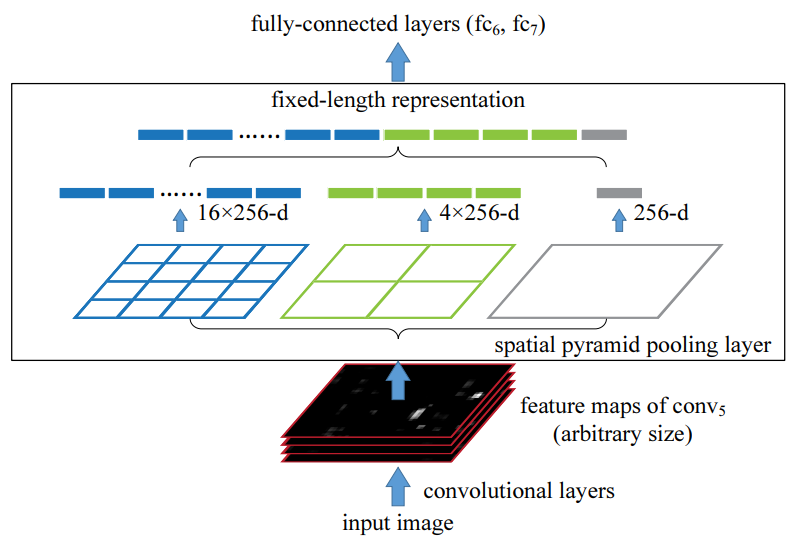

In [45]:
# Method 2
import torch,math
import torch.nn.functional as F

# 构建SPP层(空间金字塔池化层)
class SPPLayer(torch.nn.Module):
    def __init__(self, num_levels, pool_type='max_pool'):
        super(SPPLayer, self).__init__()
        self.num_levels = num_levels
        self.pool_type = pool_type
        
    def forward(self,x):
        num,c,h,w = x.size()# num:样本数量 c:通道数 h:高 w:宽
        for i in range(self.num_levels):
            level = i+1
            kernel_size = (math.ceil(h / level), math.ceil(w / level))
            stride = (math.ceil(h / level), math.ceil(w / level))
            pooling = (math.floor((kernel_size[0]*level-h+1)/2), math.floor((kernel_size[1]*level-w+1)/2))
                      
            # 选择池化方式 
            if self.pool_type == 'max_pool':
                tensor = F.max_pool2d(x, kernel_size=kernel_size, stride=stride, padding=pooling).view(num, -1)
            else:
                tensor = F.avg_pool2d(x, kernel_size=kernel_size, stride=stride, padding=pooling).view(num, -1)
                
            print('level =',level)
            print('kernel_size =',kernel_size)
            print('stride =',stride)
            print('pooling =',pooling) 
            print(F.max_pool2d(x, kernel_size=kernel_size, stride=stride, padding=pooling).shape)
            print('*'*30)
            
            # 展开、拼接
            if (i == 0):
                x_flatten = tensor.view(num, -1)
            # 第一个之后都要拼接上去
            else:
                x_flatten = torch.cat((x_flatten, tensor.view(num, -1)), 1)
        return x_flatten        

In [48]:
x = torch.rand((2,512,15,15))    
f = SPPLayer(2)
print('SPP out shape =',f(x).shape)
print('\n2560 = 512*1*1+512*2*2')

level = 1
kernel_size = (15, 15)
stride = (15, 15)
pooling = (0, 0)
torch.Size([2, 512, 1, 1])
******************************
level = 2
kernel_size = (8, 8)
stride = (8, 8)
pooling = (1, 1)
torch.Size([2, 512, 2, 2])
******************************
SPP out shape = torch.Size([2, 2560])

2560 = 512*1*1+512*2*2
